<a href="https://colab.research.google.com/github/sakshamchecker/AmazonProductRecommendation/blob/main/AmazonProductRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduction : 
This MTE project is based on basic working of NLP methods that can be used in E-Commerce websites as recommendation systems. 
The data is taken from the website - Applied AI. 
The Link of the data is given below- https://drive.google.com/drive/folders/1K_BSjfQjZdHhy9qtQdGi032egY8sPJD5?usp=sharing
The data was originally obtained using the Amazon products API. 


###Data Loading

In [ ]:

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack


In [ ]:
data = pd.read_json('/content/drive/MyDrive/AmazonProductRecommendation/tops_fashion.json')

In [ ]:
print ('Number of data points : ', data.shape[0], 'Number of features/variables:', data.shape[1])

Number of data points :  183138 Number of features/variables: 19


In [ ]:
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

Of these 19 features, we will be using only 6 features in this workshop. 1. asin ( Amazon standard identification number) 2. brand ( brand to which the product belongs to ) 3. color ( Color information of apparel, it can contain many colors as a value ex: red and black stripes ) 4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT ) 5. medium_image_url ( url of the image ) 6. title (title of the product.) 7. formatted_price (price of the product)

In [ ]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [ ]:
print ('Number of data points : ', data.shape[0], 'Number of features:', data.shape[1])

Number of data points :  183138 Number of features: 7


In [ ]:
data.head()

asin  ... formatted_price
0  B016I2TS4W  ...            None
1  B01N49AI08  ...            None
2  B01JDPCOHO  ...            None
3  B01N19U5H5  ...            None
4  B004GSI2OS  ...          $26.26

[5 rows x 7 columns]

In [ ]:
# We have total 72 unique type of product_type_names
print(data['product_type_name'].describe())

# 91.62% (167794/183138) of the products are shirts,|

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [ ]:
# names of different product types
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [ ]:
# Top 10 product types
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

In [ ]:
# there are 10577 unique brands
print(data['brand'].describe())

# 183138 - 182987 = 151 missing values.

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [ ]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

In [ ]:

print(data['color'].describe())


# we have 7380 unique colors
# 7.2% of products are black in color
# 64956 of 183138 products have brand information. That's approx 35.4%.

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [ ]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

In [ ]:
print(data['formatted_price'].describe())

# Only 28,395 (15.5% of whole data) products with price information

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [ ]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

In [ ]:
print(data['title'].describe())

# All of the products have a title. 
# Titles are fairly descriptive of what the product is. 
# We use titles extensively in this workshop 
# as they are short and informative.


count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [ ]:
!mkdir "/content/drive/MyDrive/AmazonProductRecommendation/pickels"

mkdir: cannot create directory ‘/content/drive/MyDrive/AmazonProductRecommendation/pickels’: File exists


In [ ]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 178026


In [ ]:
data.iloc[0]

asin                                                        B016I2TS4W
brand                                                            FNC7C
color                                                             None
medium_image_url     https://images-na.ssl-images-amazon.com/images...
product_type_name                                                SHIRT
title                minions como superheroes ironman long sleeve r...
formatted_price                                                   None
Name: 0, dtype: object

In [ ]:
data.shape

(183138, 7)

In [ ]:
data.to_pickle('/content/drive/MyDrive/AmazonProductRecommendation/pickels/180k_apparel_data')

In [ ]:
data = pd.read_pickle("/content/drive/MyDrive/AmazonProductRecommendation/pickels/180k_apparel_data")

In [ ]:
# Sort the whole data based on title (alphabetical order of title) 
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

asin  ... formatted_price
27547  B073W7P8KK  ...            None
31277  B01M0PWMZ8  ...            None
30453  B01M02GWRG  ...            None
32485  B01N0ADXM0  ...            None
26767  B01MTQAU86  ...            None

[5 rows x 7 columns]

###De Duplication

The 180k data points with selected features are now further filtered as the duplicate names are removed. Data points having title with 2 same words are removed. The process of removing the datapoints with three words as duplicates is not removed as the code is of high time complexity and even on 1/10th sized data, it takes 1 hour to run on a decent machine

Some examples of dupliacte titles that differ only in the last few words.

In [ ]:
data = pd.read_pickle("/content/drive/MyDrive/AmazonProductRecommendation/pickels/180k_apparel_data")

In [ ]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [ ]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])


            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [ ]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

In [ ]:
print('Number of data points : ', data.shape[0])

Number of data points :  151251


151k items are left now. 

In [ ]:

# # This code snippet takes significant amount of time.
# # O(n^2) time.

# indices = []
# for i,row in data.iterrows():
#     indices.append(i)

# stage2_dedupe_asins = []
# while len(indices)!=0:
#     i = indices.pop()
#     stage2_dedupe_asins.append(data['asin'].loc[i])
#     # consider the first apperal's title
#     a = data['title'].loc[i].split()
#     # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
#     for j in indices:
        
#         b = data['title'].loc[j].split()
#         # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
#         length = max(len(a),len(b))
        
#         # count is used to store the number of words that are matched in both strings
#         count  = 0

#         # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
#         # example: a =['a', 'b', 'c', 'd']
#         # b = ['a', 'b', 'd']
#         # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
#         for k in itertools.zip_longest(a,b): 
#             if (k[0]==k[1]):
#                 count += 1

#         # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
#         if (length - count) < 3:
#             indices.remove(j)


In [ ]:
print('Number of data points : ', data.shape[0])

Number of data points :  151251


In [ ]:
data.to_pickle('/content/drive/MyDrive/AmazonProductRecommendation/pickels/DataFinal')

###Text Preprocessing

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/AmazonProductRecommendation/pickels/DataFinal')

In [ ]:
data.shape

(151251, 7)

All the stop words are removed now

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'same', 'me', 'their', 'if', 'haven', 'can', 'll', "shan't", 'of', 'he', 'nor', 'your', 'more', 'needn', 'again', 'ours', 'what', 'about', 'over', 'do', 'd', 'her', 'for', 'out', 'been', 'at', 'y', "you'd", 'those', "that'll", 'ain', 'we', 'after', 'there', 'shouldn', 'had', 'our', 'didn', "won't", 'but', 'wouldn', 'on', 'very', "hasn't", 'through', "she's", 'when', 'doesn', 'few', "doesn't", 'before', 'shan', 'other', "you'll", 'these', 'will', "couldn't", "didn't", 'that', 'such', "mightn't", 'above', 'then', 'and', 'which', 'hasn', 'mustn', 'in', "it's", 'yourself', 'yours', 'being', 'until', 'did', "wasn't", 'because', 'won', 'an', 'herself', 'how', 'all', 'itself', 'who', 'no', 'has', 're', 'myself', 'i', 'some', 'why', 'than', "don't", 'so', 'now', 'under', "you're", 't', 'o', 'whom', 'further', 'not', "wouldn't", 'isn', 'only', 'my', 'you', 'themselves', 'off', "should've", 'each', 'during', 'they', 'having', 'm', 'it', 'once', 'this', 'as', 'his', 'them', '

In [ ]:
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')

In [ ]:
data.to_pickle('/content/drive/MyDrive/AmazonProductRecommendation/pickels/Data_final_preprocessed')

###Text Based product similarity

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from plotly.graph_objs import Scatter, Layout

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/AmazonProductRecommendation/pickels/Data_final_preprocessed')

In [ ]:
# Utility Functions which we will use through the rest of the workshop.


#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() 

(151251, 42835)

**Bag of words**

In [ ]:
def bag_of_words_model(doc_id, num_results):
   
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)
        

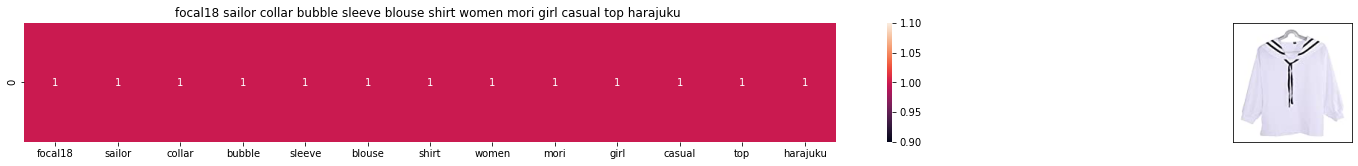

ASIN : B01N19U5H5
Brand: Focal18
Title: focal18 sailor collar bubble sleeve blouse shirt women mori girl casual top harajuku 
Euclidean similarity with the query image : 0.0


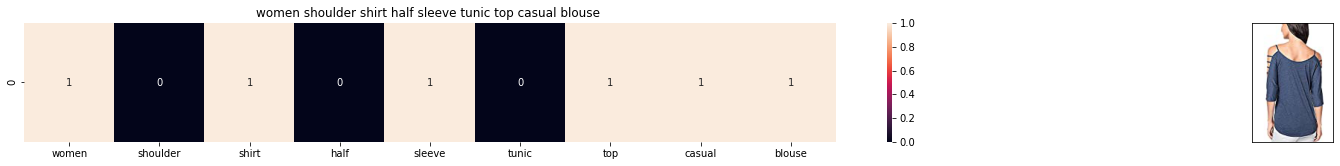

ASIN : B01G5DBM7U
Brand: U-Kiss
Title: women shoulder shirt half sleeve tunic top casual blouse 
Euclidean similarity with the query image : 3.1622776601683795


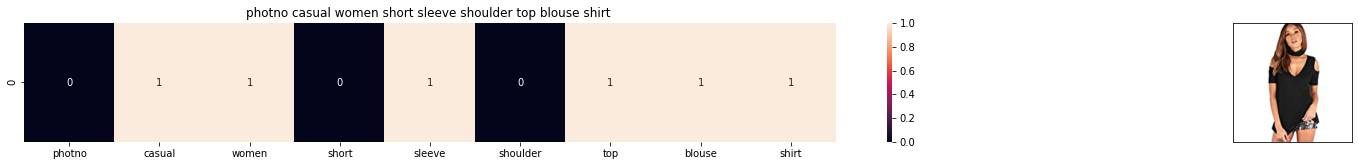

ASIN : B071H6VC4P
Brand: PHOTNO
Title: photno casual women short sleeve shoulder top blouse shirt 
Euclidean similarity with the query image : 3.1622776601683795


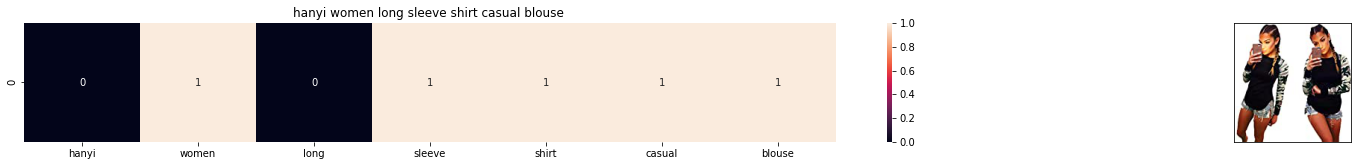

ASIN : B01LYSKVZ1
Brand: HANYI
Title: hanyi women long sleeve shirt casual blouse 
Euclidean similarity with the query image : 3.1622776601683795


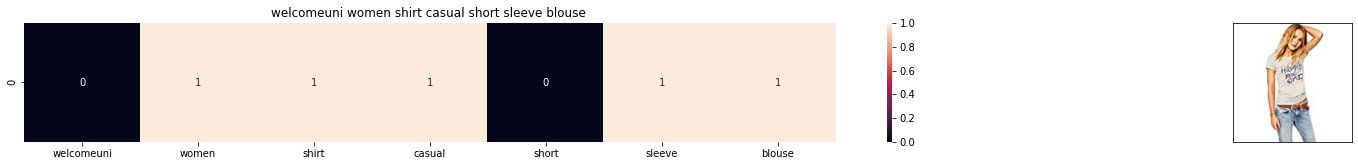

ASIN : B01DD3M0MG
Brand: welcomeuni 1340
Title: welcomeuni women shirt casual short sleeve blouse 
Euclidean similarity with the query image : 3.1622776601683795


In [ ]:
bag_of_words_model(1, 5)

**TFIDF**

In [ ]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
# tfidf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# tfidf_title_features[doc_id, index_of_word_in_corpus] = tfidf values of the word in given doc

In [ ]:
def tfidf_model(doc_id, num_results):
    
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])

        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)

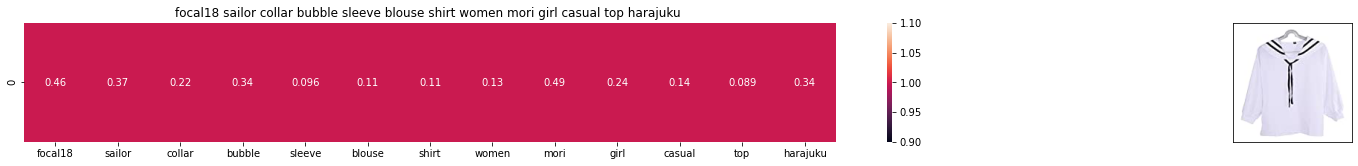

ASIN : B01N19U5H5
BRAND : Focal18
Title: focal18 sailor collar bubble sleeve blouse shirt women mori girl casual top harajuku 
Eucliden distance from the given image : 0.0


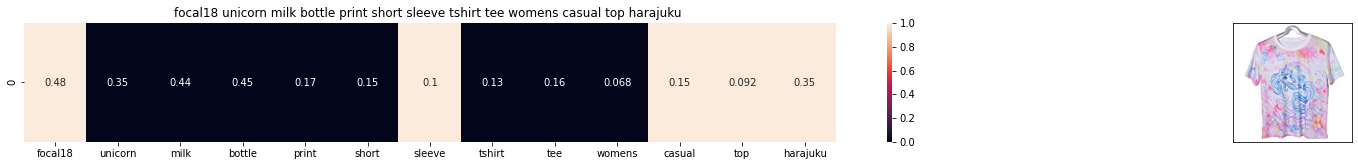

ASIN : B06W51XX12
BRAND : Focal18
Title: focal18 unicorn milk bottle print short sleeve tshirt tee womens casual top harajuku 
Eucliden distance from the given image : 1.119166252210056


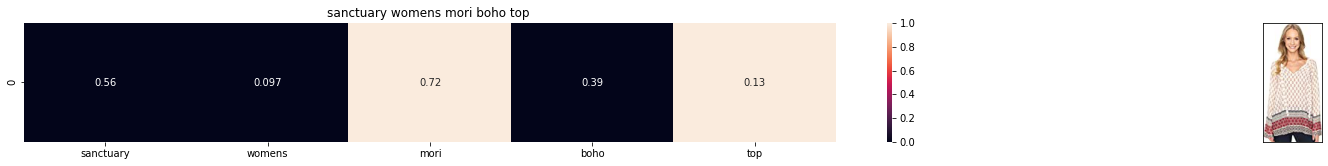

ASIN : B01JBL2Q32
BRAND : Sanctuary Clothing
Title: sanctuary womens mori boho top 
Eucliden distance from the given image : 1.129810326111054


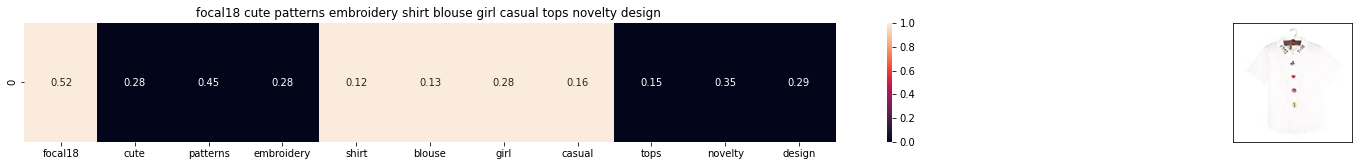

ASIN : B06W2LSCWB
BRAND : Focal18
Title: focal18 cute patterns embroidery shirt blouse girl casual tops novelty design 
Eucliden distance from the given image : 1.134735406639773


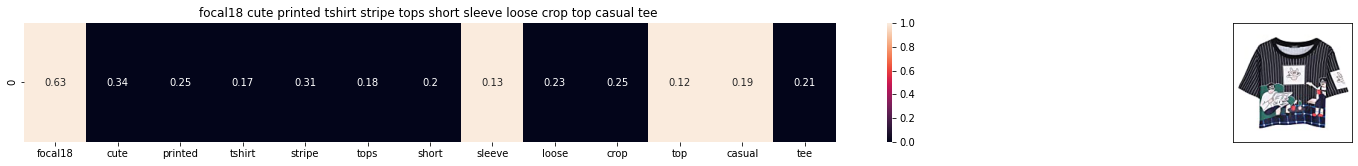

ASIN : B06VWJFFH7
BRAND : Focal18
Title: focal18 cute printed tshirt stripe tops short sleeve loose crop top casual tee 
Eucliden distance from the given image : 1.147529362212152


In [ ]:
tfidf_model(1, 5)

**IDF**

In [ ]:
data =data.loc[~data['color'].isnull()]
data =data.loc[~data['brand'].isnull()]
data =data.loc[~data['product_type_name'].isnull()]
data =data.loc[~data['title'].isnull()]

In [ ]:
data = pd.read_pickle("/content/drive/MyDrive/AmazonProductRecommendation/pickels/28k_apperal_data_preprocessed")

In [ ]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

In [ ]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [ ]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
        

In [ ]:
pd.to_pickle(idf_title_features, '/content/drive/MyDrive/AmazonProductRecommendation/pickels/idf_title_features)')

In [ ]:
import pickle
with open('/content/drive/MyDrive/AmazonProductRecommendation/pickels/idf_title_features)', 'rb') as f:
    idf_title_features = pickle.load(f)

In [ ]:
data

<28385x13873 sparse matrix of type '<class 'numpy.float64'>'
	with 255522 stored elements in Compressed Sparse Row format>

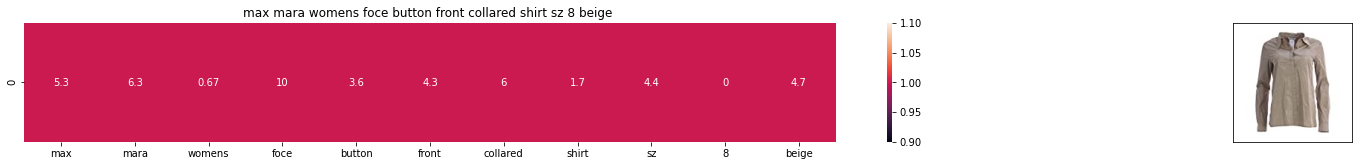

ASIN : B0749S36YR
Brand : MaxMara
euclidean distance from the given image : 0.0


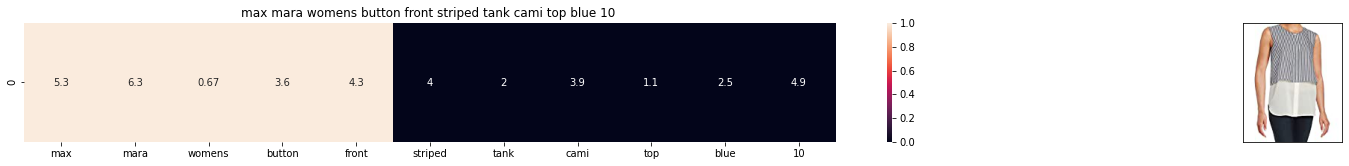

ASIN : B0758KDRF8
Brand : MaxMara
euclidean distance from the given image : 15.910834753686084


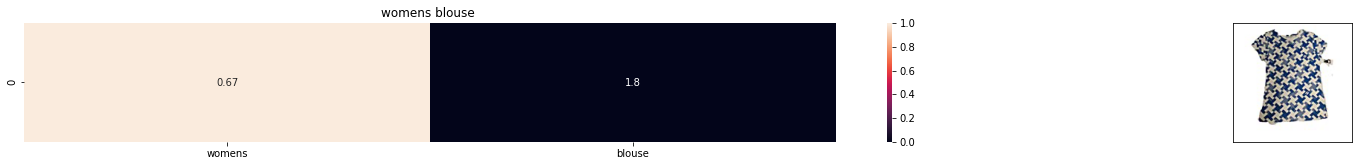

ASIN : B01MQ2MH0A
Brand : DC
euclidean distance from the given image : 16.950341394180743


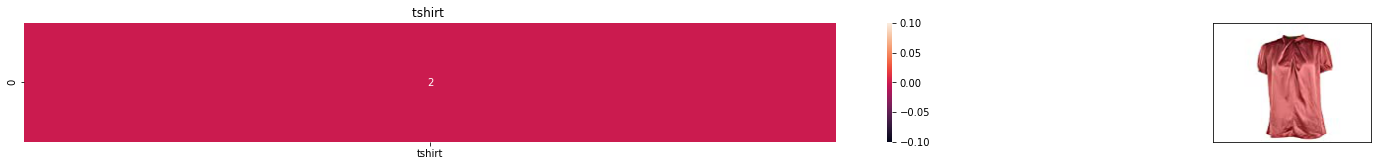

ASIN : B074PMR69Q
Brand : General
euclidean distance from the given image : 16.990285553681723


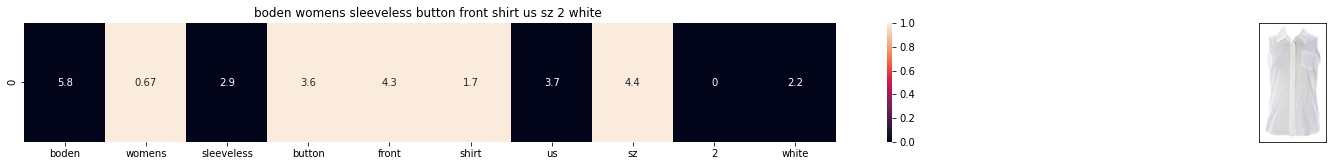

ASIN : B01H62U75W
Brand : BODEN
euclidean distance from the given image : 17.08452580258382


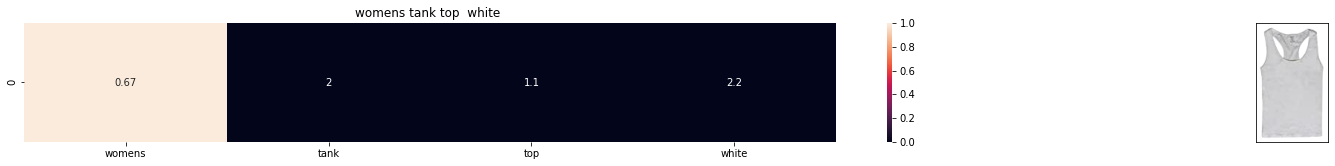

ASIN : B00JPOZ9GM
Brand : Sofra
euclidean distance from the given image : 17.14532866174503


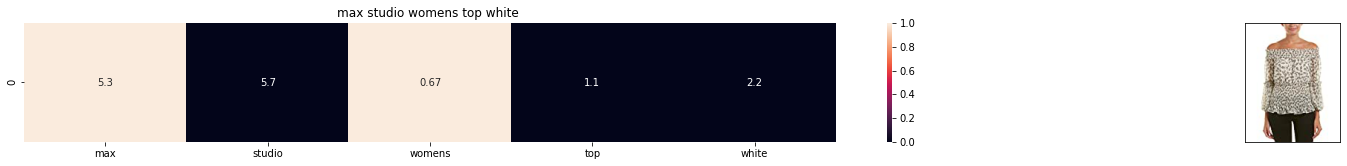

ASIN : B074LB4WN1
Brand : MAXSTUDIO
euclidean distance from the given image : 17.159420124313645


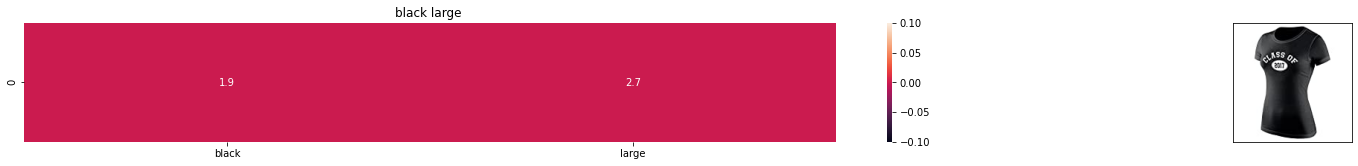

ASIN : B0746G2NZQ
Brand : Cherry Bobby
euclidean distance from the given image : 17.18554809478451


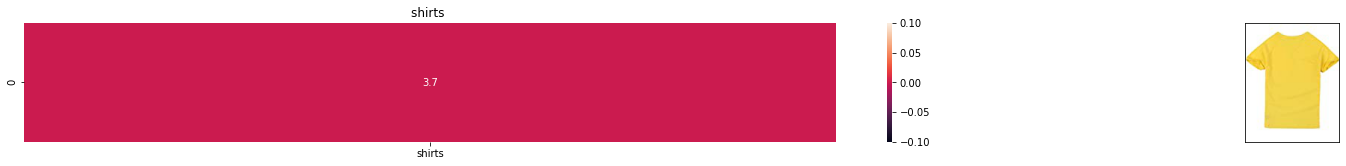

ASIN : B074HZVQRL
Brand : General
euclidean distance from the given image : 17.26907388494083


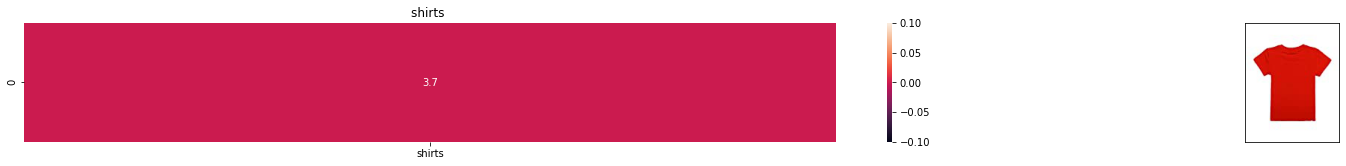

ASIN : B074PJZFPQ
Brand : General
euclidean distance from the given image : 17.26907388494083


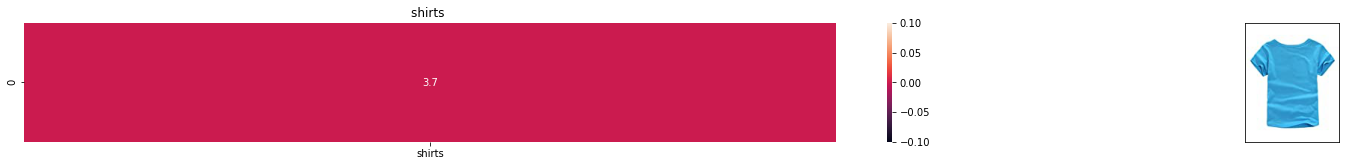

ASIN : B074J7886V
Brand : General
euclidean distance from the given image : 17.26907388494083


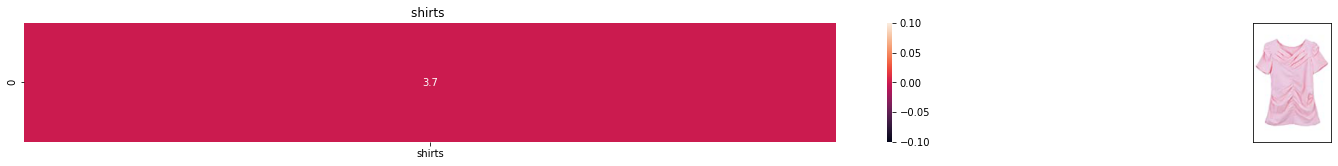

ASIN : B074PKQ2M6
Brand : General
euclidean distance from the given image : 17.26907388494083


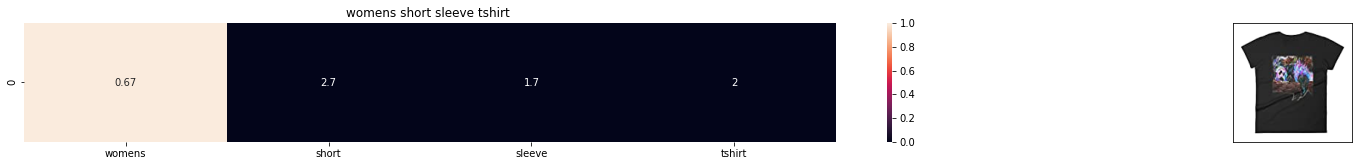

ASIN : B073WVC9RQ
Brand : Starchild's Designs
euclidean distance from the given image : 17.274128247895934


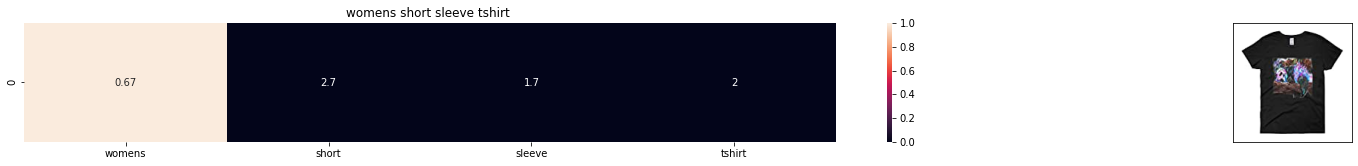

ASIN : B073WVBCHZ
Brand : Starchild's Designs
euclidean distance from the given image : 17.274128247895934


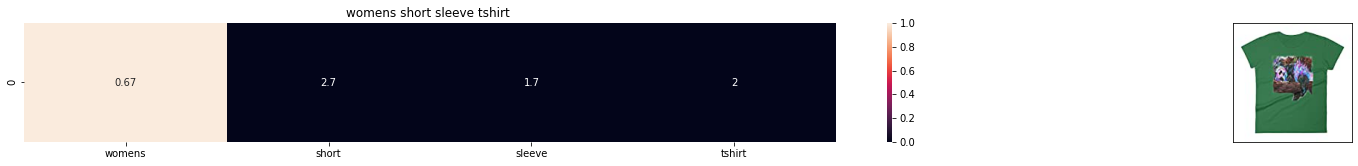

ASIN : B073WVPHL9
Brand : Starchild's Designs
euclidean distance from the given image : 17.274128247895934


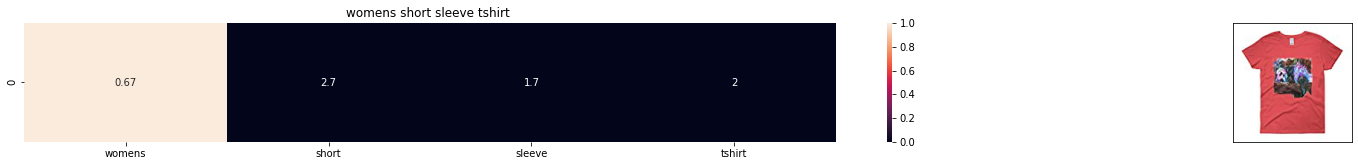

ASIN : B073WVHSBX
Brand : Starchild's Designs
euclidean distance from the given image : 17.274128247895934


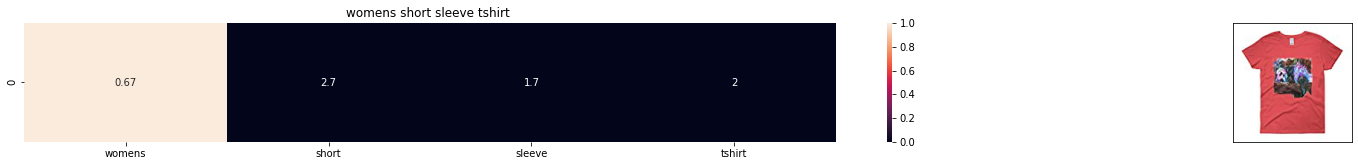

ASIN : B073WVNXXF
Brand : Starchild's Designs
euclidean distance from the given image : 17.274128247895934


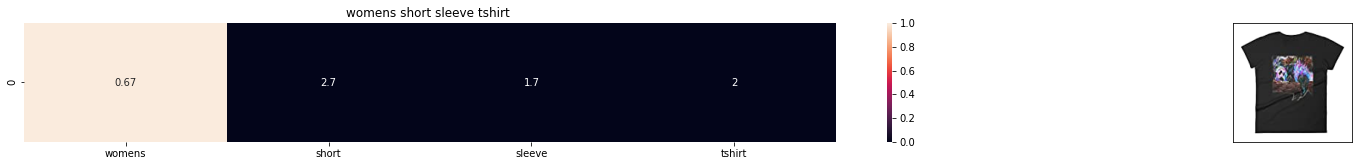

ASIN : B073WVVTB4
Brand : Starchild's Designs
euclidean distance from the given image : 17.274128247895934


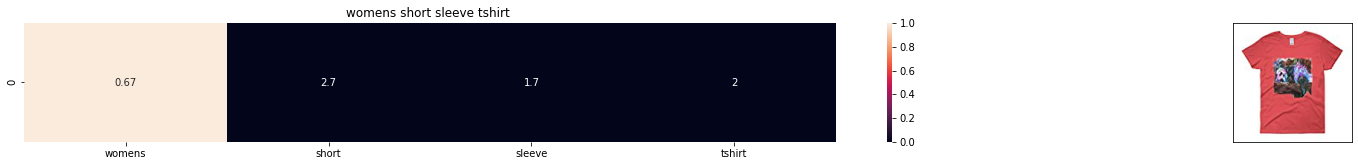

ASIN : B073WVHG2T
Brand : Starchild's Designs
euclidean distance from the given image : 17.274128247895934


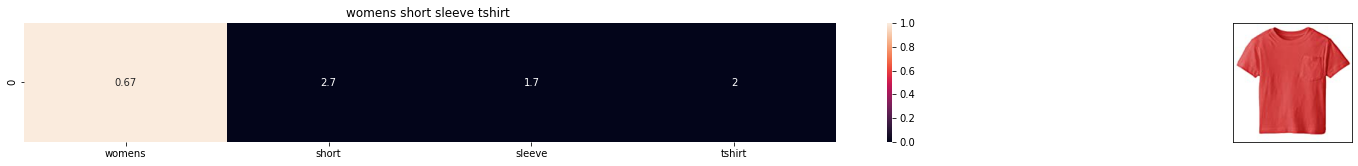

ASIN : B074MPHZNM
Brand : Magic
euclidean distance from the given image : 17.274128247895934


In [ ]:
def idf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)

        
        
idf_model(19584,20)
# in the output heat map each value represents the idf values of the label word, the color represents the intersection with inputs title

###Text Semantics based product similarity

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


In [ ]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from plotly.graph_objs import Scatter, Layout
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff


In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/AmazonProductRecommendation/pickels/28k_apperal_data_preprocessed')

In [ ]:
data.shape

(28385, 7)

In [ ]:
'''
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 1    # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(sen_corpus, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context)
    
'''
###This model should only be trained when the number of data entries are more. 

In [ ]:
with open('/content/drive/MyDrive/AmazonProductRecommendation/word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [ ]:
def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [ ]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [ ]:
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    try:
      response = requests.get(url)
      img = Image.open(BytesIO(response.content))
      # we will display it in notebook 
      plt.imshow(img)
    except:
      pass

#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    
    

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

**Avg w2c**

In [ ]:
doc_id = 0
w2v_title = []
# for every title we build a avg vector representation
for i in data['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title = np.array(w2v_title)

In [ ]:
def avg_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from given input image :', pdists[i])
        print('='*125)

        

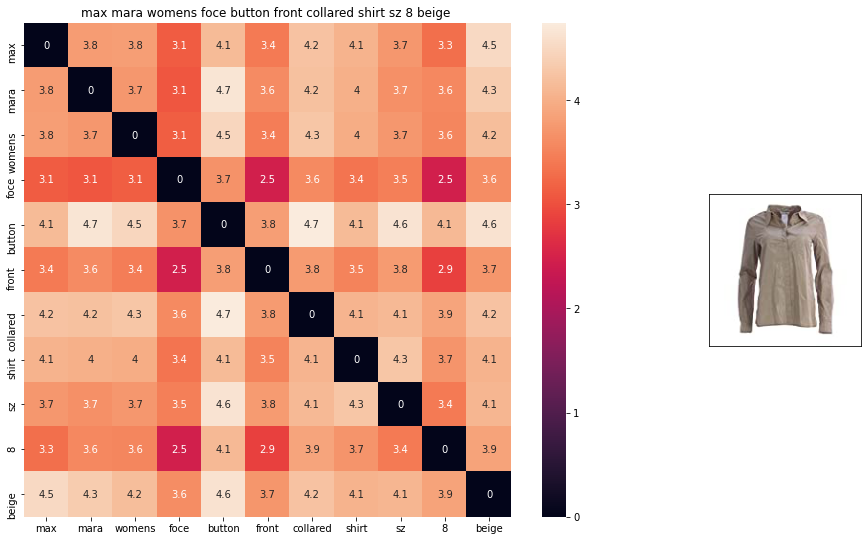

ASIN : B0749S36YR
BRAND : MaxMara
euclidean distance from given input image : 0.0


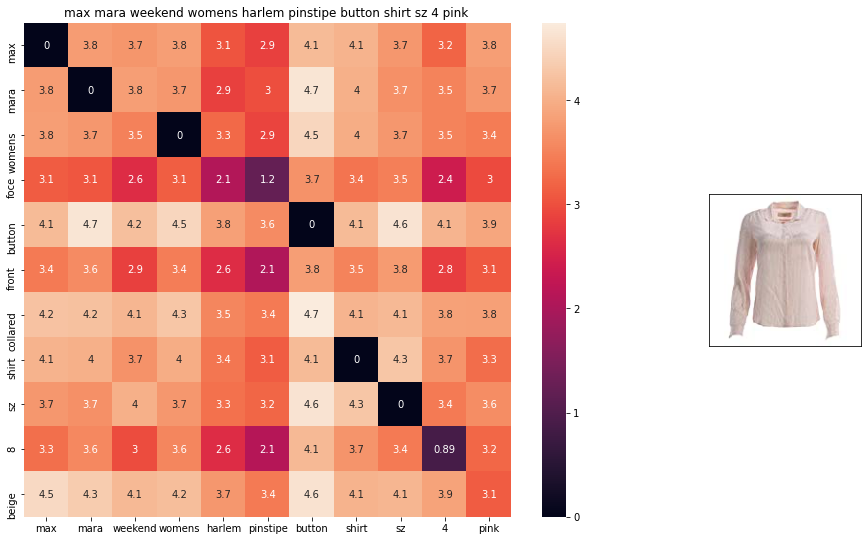

ASIN : B0749S8BQ7
BRAND : MaxMara
euclidean distance from given input image : 0.5466822


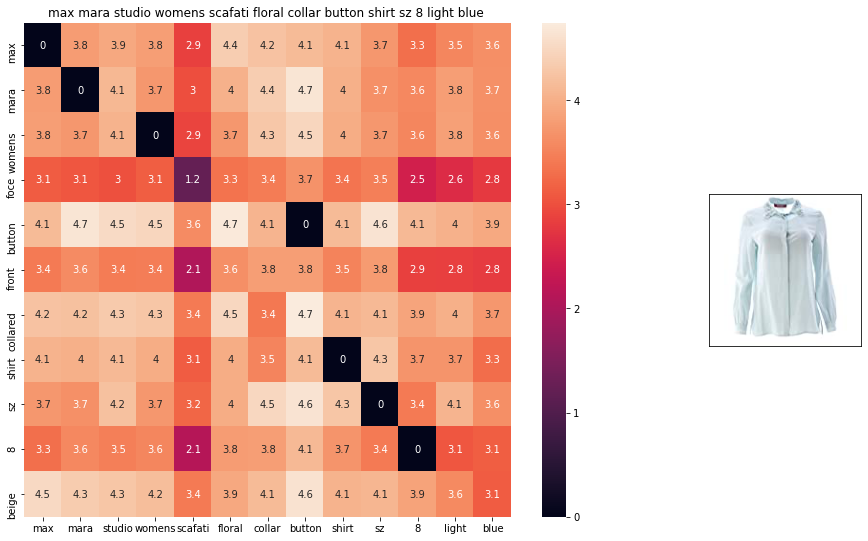

ASIN : B06XH7N85D
BRAND : MaxMara
euclidean distance from given input image : 0.56413823


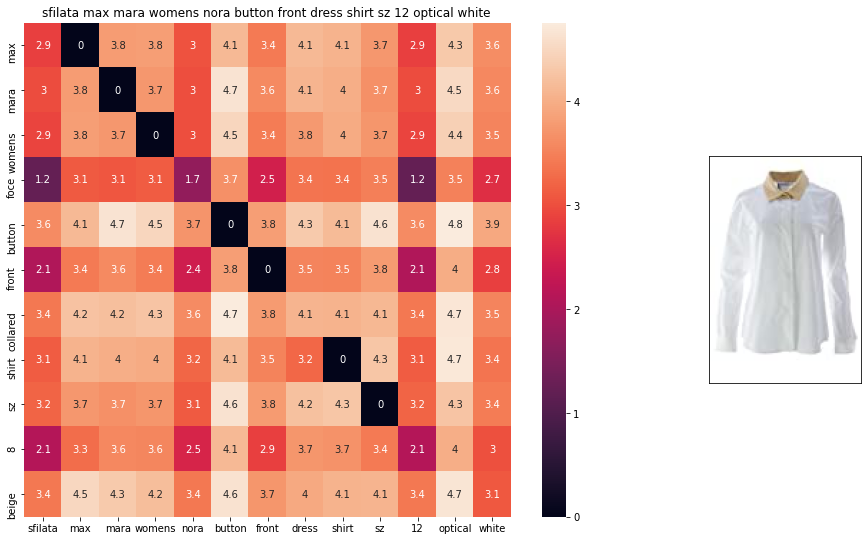

ASIN : B01N6AWF0N
BRAND : MaxMara
euclidean distance from given input image : 0.5824607


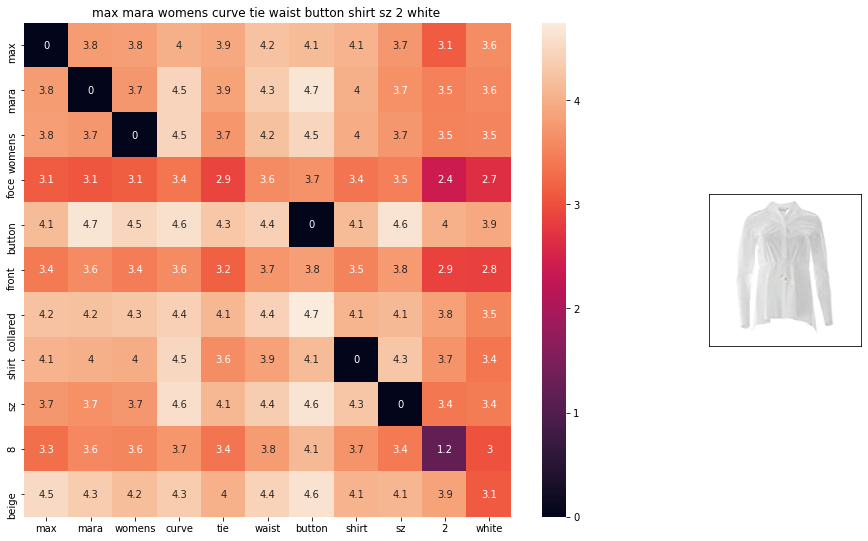

ASIN : B06WWJQ3P2
BRAND : MaxMara
euclidean distance from given input image : 0.6246925


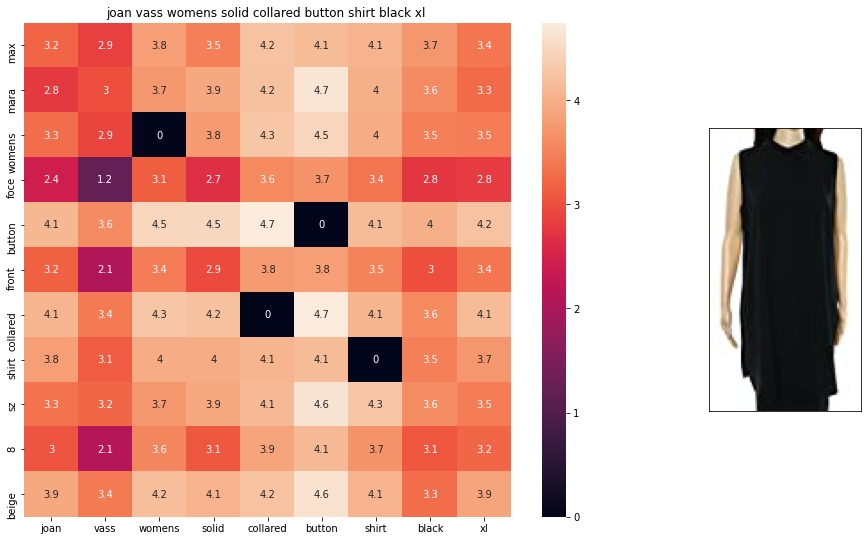

ASIN : B074VBFQ1X
BRAND : Joan Vass
euclidean distance from given input image : 0.6629441


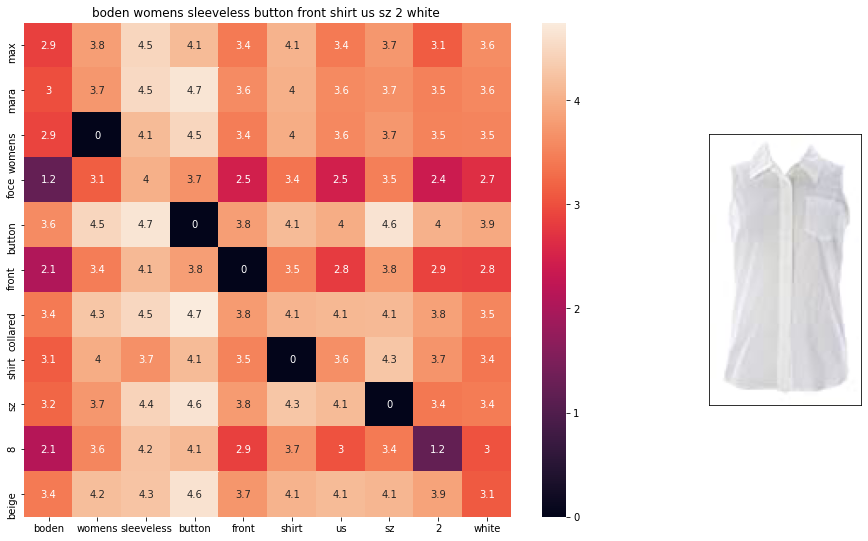

ASIN : B01H62U75W
BRAND : BODEN
euclidean distance from given input image : 0.67210203


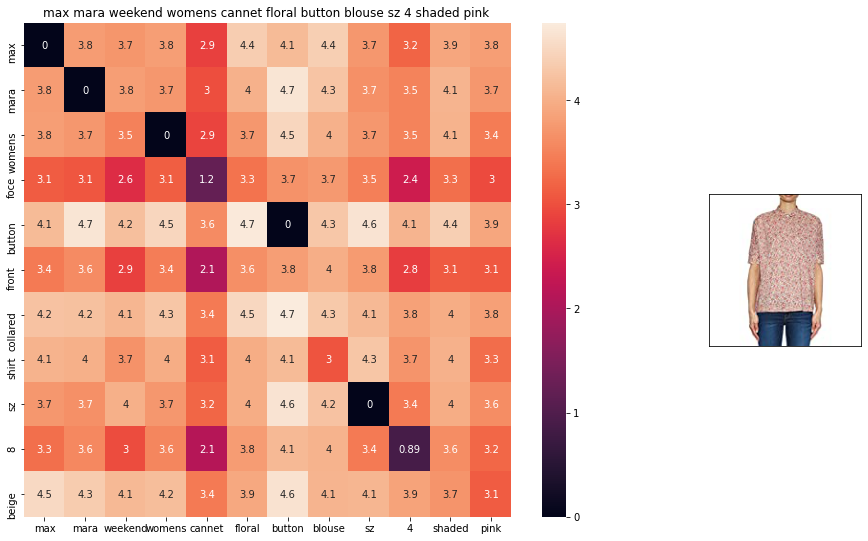

ASIN : B0713WJH8J
BRAND : MaxMara
euclidean distance from given input image : 0.683017


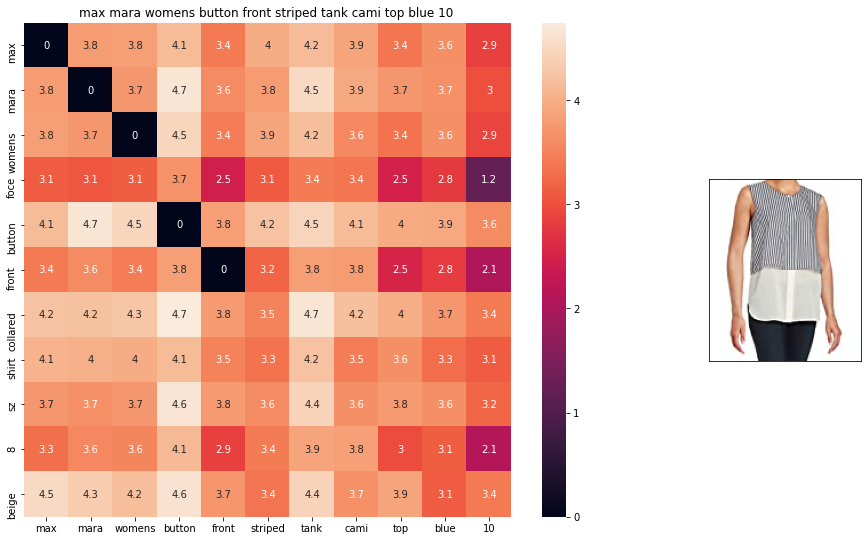

ASIN : B0758KDRF8
BRAND : MaxMara
euclidean distance from given input image : 0.70455915


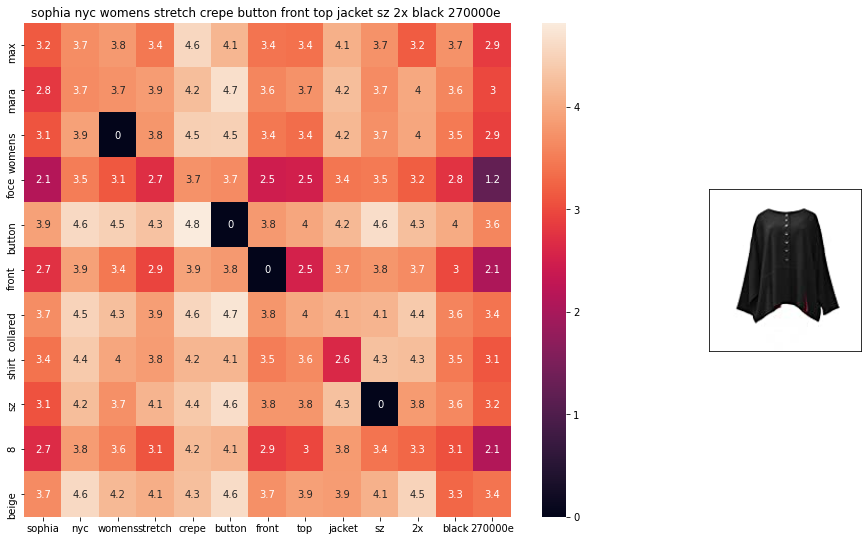

ASIN : B07522YS8B
BRAND : Sophia NYC
euclidean distance from given input image : 0.7095665


In [ ]:
avg_w2v_model(19584, 10)

Brand and Colour based

In [ ]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [ ]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [ ]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

In [ ]:
def idf_w2v_brand(doc_id, w1, w2, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist)/float(w1 + w2)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

# in the give heat map, each cell contains the euclidean distance between words i, j

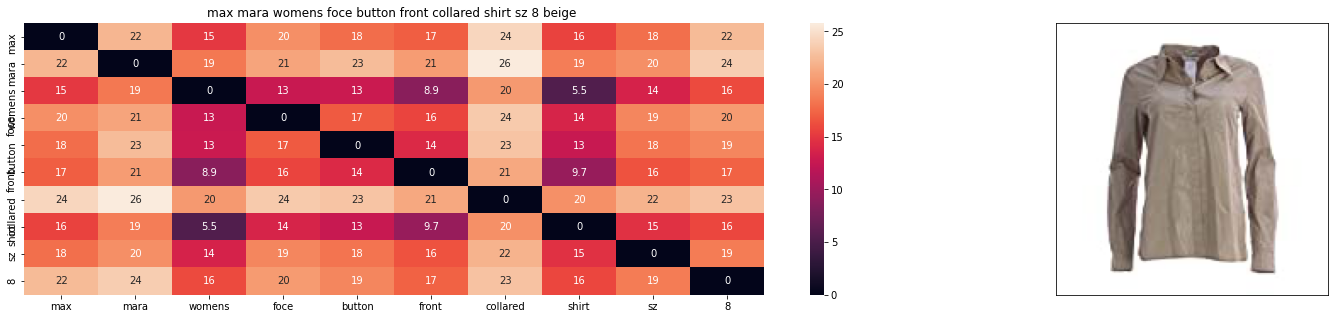

ASIN : B0749S36YR
Brand : MaxMara
euclidean distance from input : 0.0


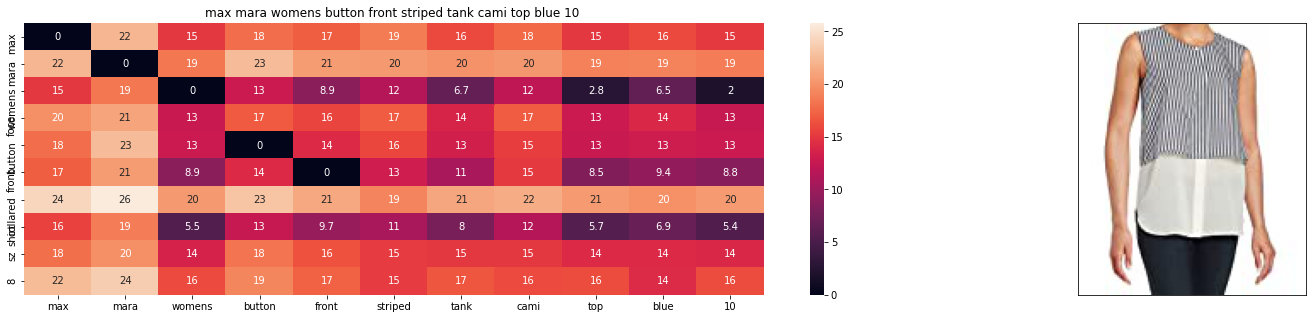

ASIN : B0758KDRF8
Brand : MaxMara
euclidean distance from input : 2.371870168170589


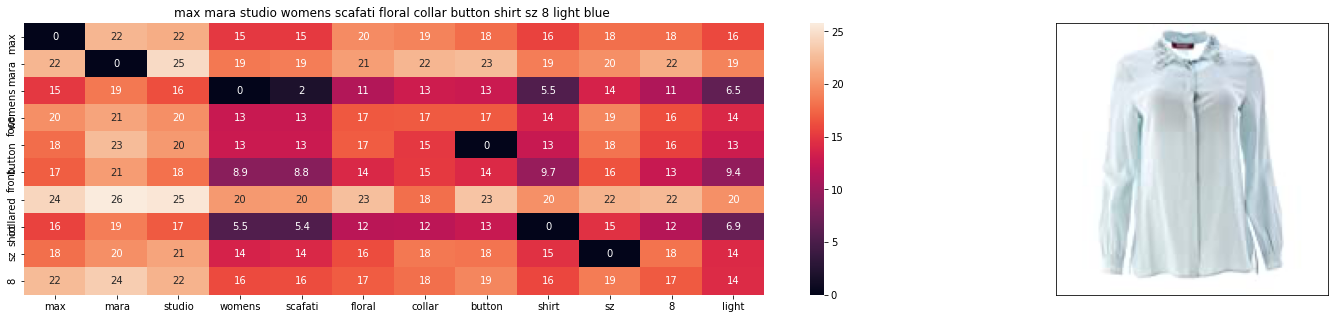

ASIN : B06XH7N85D
Brand : MaxMara
euclidean distance from input : 2.542386025618662


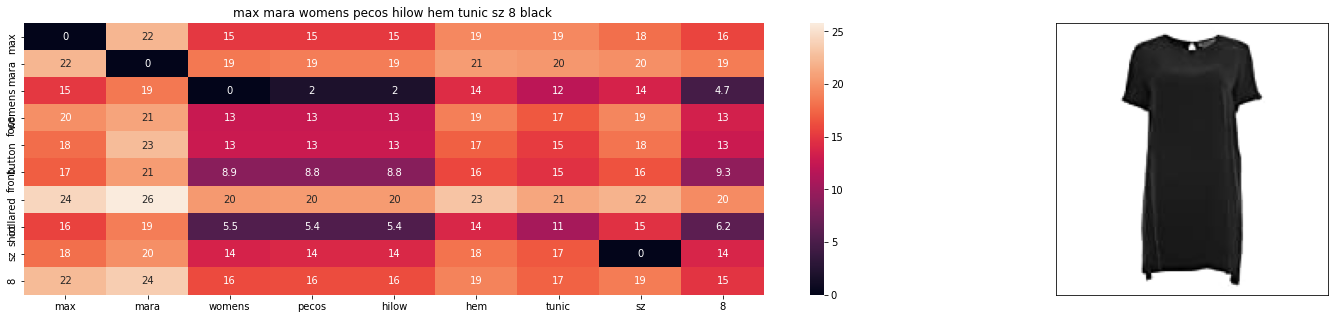

ASIN : B0749RNWZ3
Brand : MaxMara
euclidean distance from input : 2.700777435423193


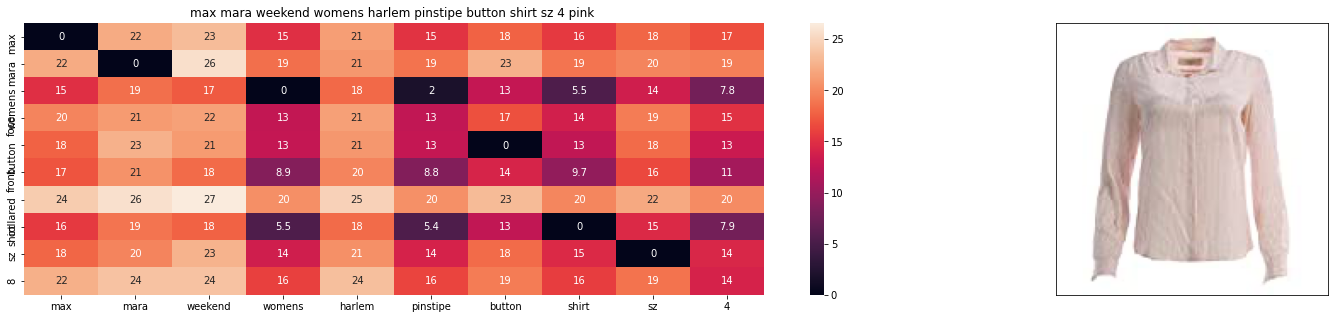

ASIN : B0749S8BQ7
Brand : MaxMara
euclidean distance from input : 2.7405446371647297


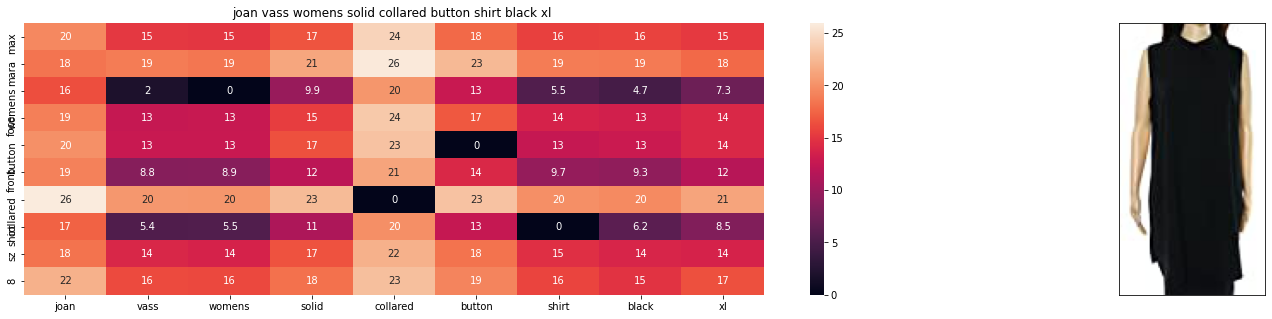

ASIN : B074VBFQ1X
Brand : Joan Vass
euclidean distance from input : 2.7747145384390572


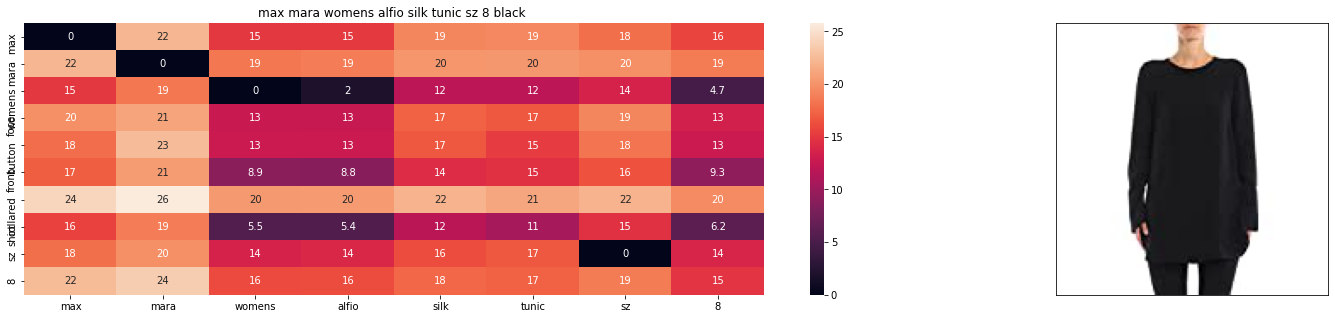

ASIN : B0749RSMGN
Brand : MaxMara
euclidean distance from input : 2.774887848020849


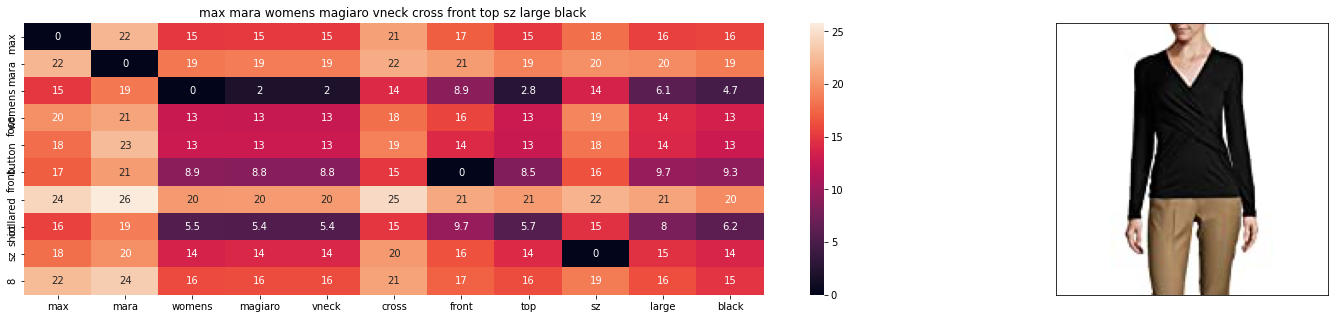

ASIN : B0749RQM72
Brand : MaxMara
euclidean distance from input : 2.8264620464257972


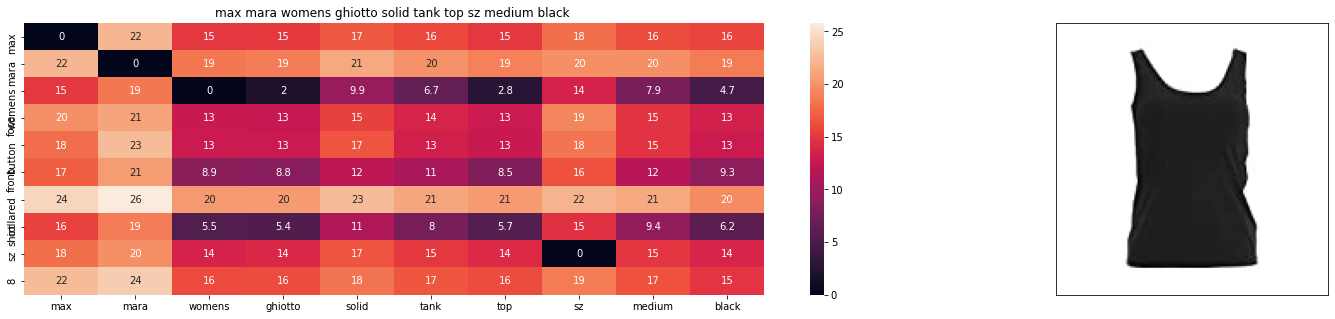

ASIN : B0749S88S3
Brand : MaxMara
euclidean distance from input : 2.8713228862695472


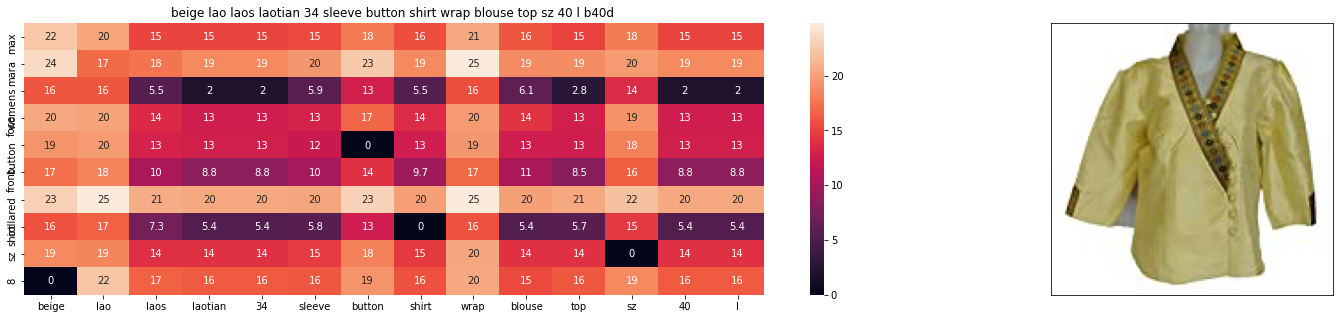

ASIN : B074GW9NFK
Brand : Nanon
euclidean distance from input : 2.886548614622412


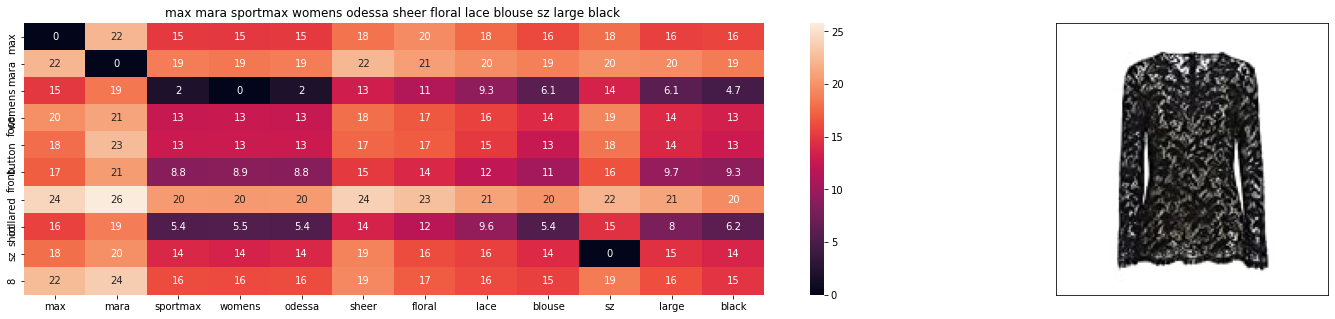

ASIN : B0749RKZ4Z
Brand : MaxMara
euclidean distance from input : 2.890712992470719


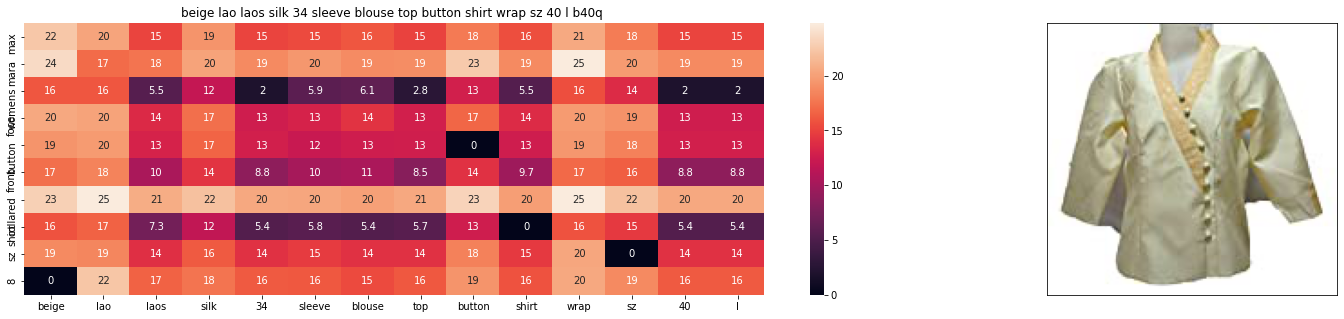

ASIN : B01LW6G077
Brand : Nanon
euclidean distance from input : 2.9010350546451984


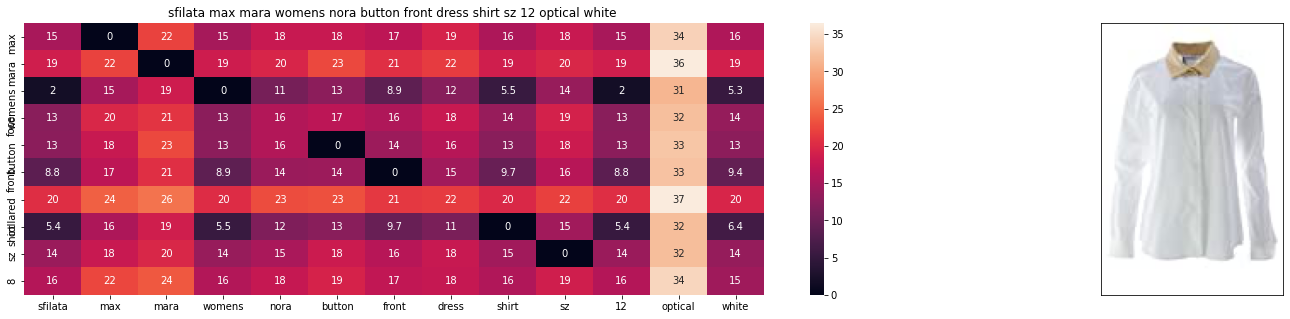

ASIN : B01N6AWF0N
Brand : MaxMara
euclidean distance from input : 2.9420678798667086


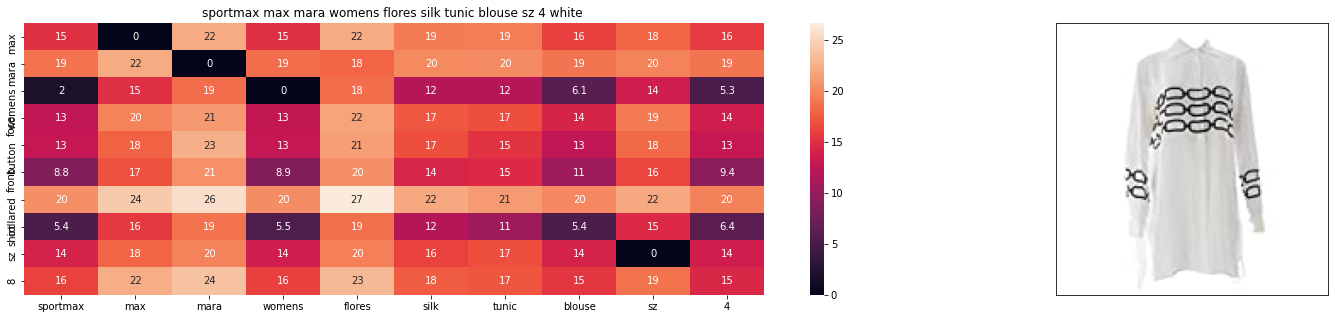

ASIN : B06X9PHLJD
Brand : MaxMara
euclidean distance from input : 2.981976572792985


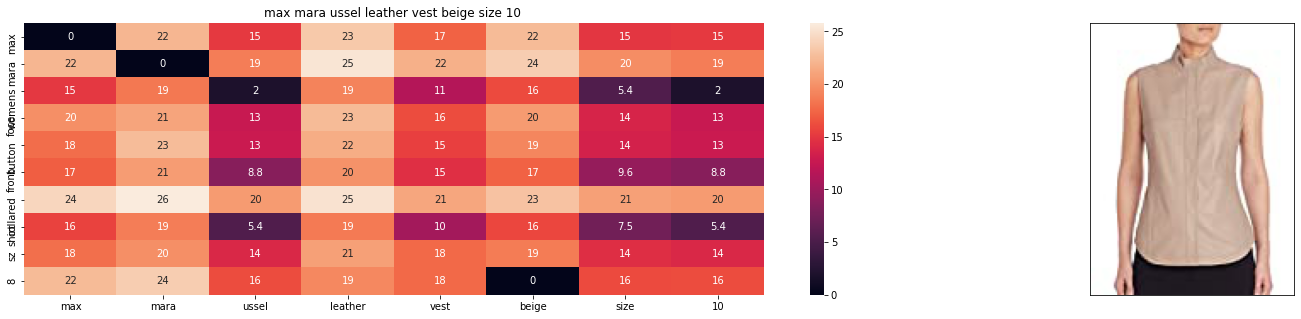

ASIN : B071WH4HCD
Brand : MaxMara
euclidean distance from input : 2.9830678305241047


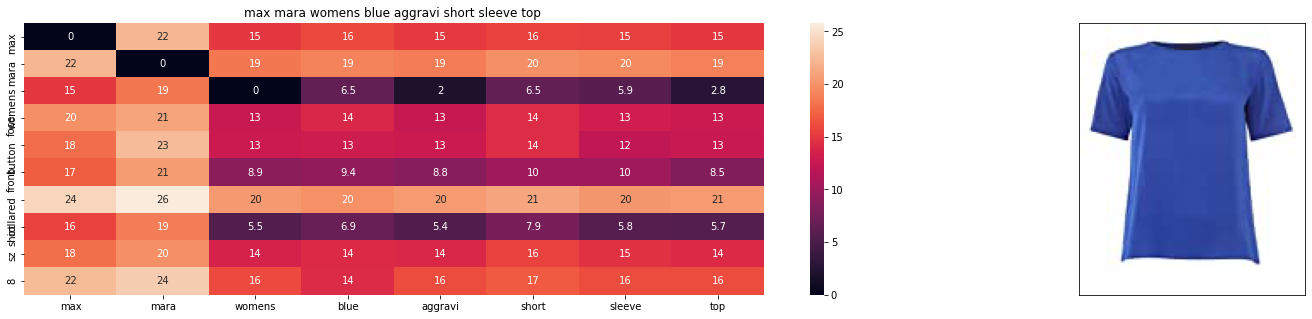

ASIN : B01M3XAV0M
Brand : Maxmara WeekEnd
euclidean distance from input : 2.9983227118165785


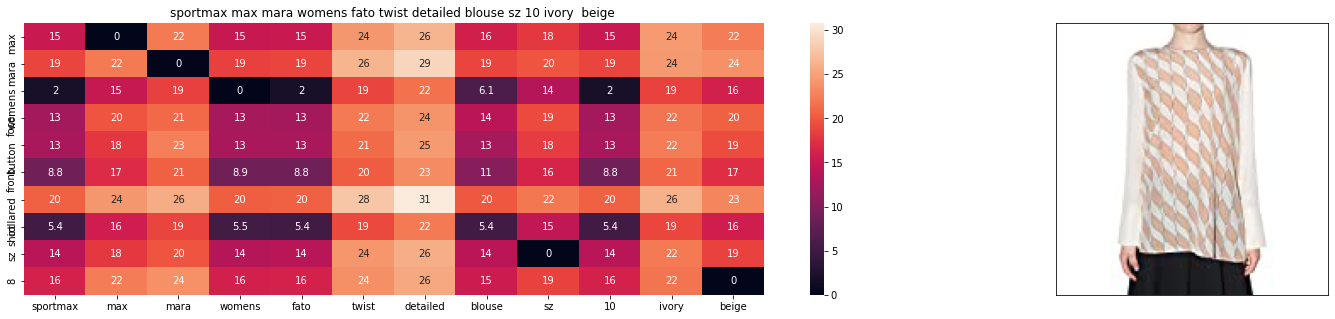

ASIN : B06XG2TBRQ
Brand : MaxMara
euclidean distance from input : 3.0062657674153646


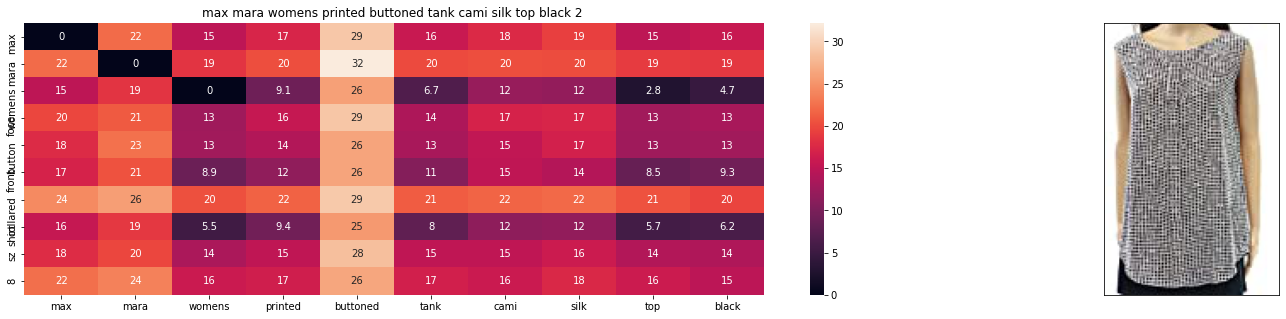

ASIN : B0746Q9RBM
Brand : MaxMara
euclidean distance from input : 3.0350756328515787


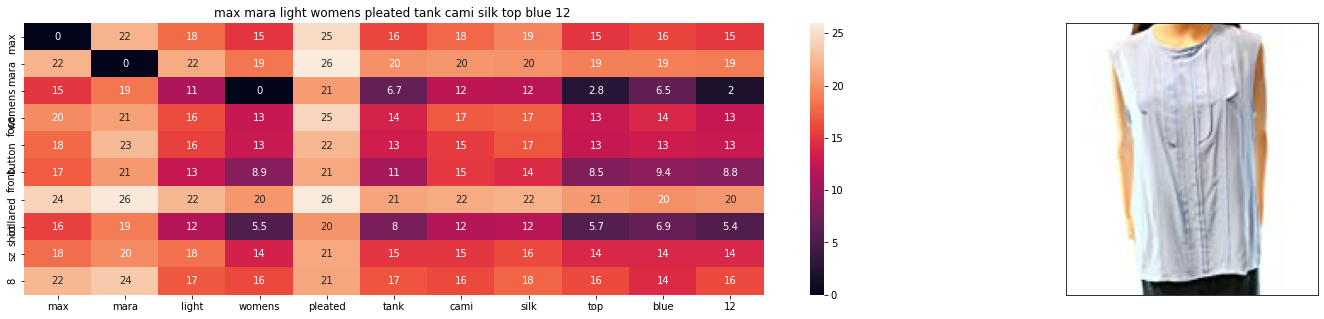

ASIN : B072184B8M
Brand : MaxMara
euclidean distance from input : 3.0382977804752764


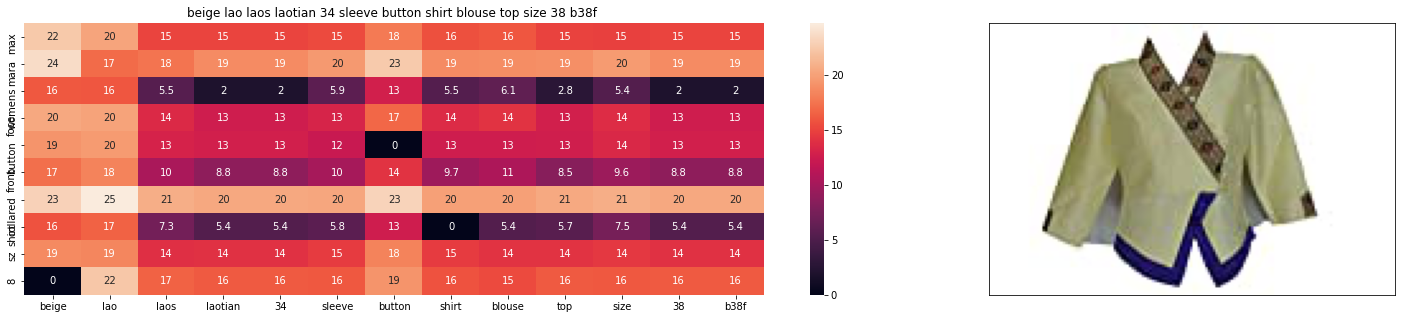

ASIN : B074GZMSTS
Brand : Nanon
euclidean distance from input : 3.04255396537111


In [ ]:
idf_w2v_brand(19584, 10, 5, 20)